### **Importing Libraries** <a id="head1"></a>

In [1]:
import numpy as np
import pandas as pd
                                                                                   
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve,roc_auc_score

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

import pickle

import warnings
warnings.filterwarnings('ignore')

### **Loading Data** <a id="head2"></a>

In [2]:
telco_customer = pd.read_csv("ChurnTrainDataset.csv")

In [3]:
telco_customer

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,OH,107.0,area_code_415,no,yes,26.0,161.6,123.0,27.47,195.5,103.0,16.62,254.4,103.0,11.45,13.7,3.0,3.70,1.0,no
1,NJ,137.0,area_code_415,no,no,0.0,243.4,114.0,41.38,121.2,110.0,10.30,162.6,104.0,7.32,12.2,5.0,3.29,0.0,no
2,OH,84.0,area_code_408,yes,no,0.0,299.4,71.0,50.90,61.9,88.0,5.26,196.9,89.0,8.86,6.6,7.0,1.78,2.0,no
3,OK,75.0,area_code_415,yes,no,0.0,166.7,113.0,28.34,148.3,122.0,12.61,186.9,121.0,8.41,10.1,3.0,2.73,3.0,no
4,MA,121.0,area_code_510,no,yes,24.0,218.2,88.0,37.09,348.5,108.0,29.62,212.6,118.0,9.57,7.5,7.0,2.03,3.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4245,MT,83.0,area_code_415,no,no,0.0,188.3,70.0,32.01,243.8,88.0,20.72,213.7,79.0,9.62,10.3,6.0,2.78,0.0,no
4246,WV,73.0,area_code_408,no,no,0.0,177.9,89.0,30.24,131.2,82.0,11.15,186.2,89.0,8.38,11.5,6.0,3.11,3.0,no
4247,NC,75.0,area_code_408,no,no,0.0,170.7,101.0,29.02,193.1,126.0,16.41,129.1,104.0,5.81,6.9,7.0,1.86,1.0,no
4248,HI,50.0,area_code_408,no,yes,40.0,235.7,127.0,40.07,223.0,126.0,18.96,297.5,116.0,13.39,9.9,5.0,2.67,2.0,no


### **Preprocessing** <a id="head5"></a>

In [4]:
# Encoding categorical data using cat codes
for col in telco_customer.columns[telco_customer.dtypes == 'object']:
    if col!='churn':
        telco_customer[col]=telco_customer[col].astype('category').cat.codes

# Fill Null Values of target column
telco_customer['churn'] =  telco_customer['churn'].fillna(telco_customer['churn'].mode()[0])

# Manual encoding the target variable
a={'yes':1,'no':0}
telco_customer['churn']=telco_customer['churn'].map(a)

### **Seperate Features & Target Variable** <a id="head6"></a>

In [5]:
X = telco_customer.drop('churn',axis=1)
y=telco_customer['churn']

In [6]:
cat_cols = X.select_dtypes(include=['int8']).columns.values

In [7]:
num_cols = X.select_dtypes(include=['float64']).columns.values

### **Train Test Split**  <a id="head7"></a>

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)

## Feature Engineering pipeline

In [9]:
# Imputation Transformer to fill null values
fill_null_col = ColumnTransformer([
        ('FillCat',SimpleImputer(strategy='most_frequent'),cat_cols),
        ('FillNumeric',SimpleImputer(strategy='median'),num_cols),
    ],remainder='passthrough')

# Scaling
scale_col = ColumnTransformer([
    ('scale', StandardScaler(),slice(5,18))
])

# Principal Component Analysis
pca_col = ColumnTransformer([
    ('PCA', PCA(n_components=10),slice(0,18))
])

# # Model
logistic=LogisticRegression()
decision=DecisionTreeClassifier()
random = RandomForestClassifier()

### **Model Pipeline** <a id="head9"></a>

In [10]:
pipeline_model1 = Pipeline([('fill_null_col', fill_null_col),
                 ('scale_col', scale_col),
                 ('pca_col', pca_col),
                 ('classifier1', logistic)])

pipeline_model2 = Pipeline([('fill_null_col', fill_null_col),
                 ('scale_col', scale_col),
                 ('pca_col', pca_col),
                 ('classifier2', decision)])

pipeline_model3 = Pipeline([('fill_null_col', fill_null_col),
                 ('scale_col', scale_col),
                 ('pca_col', pca_col),
                 ('classifier3', random)])

In [11]:
pipelines=[pipeline_model1,pipeline_model2,pipeline_model3]

In [12]:
best_accuracy=0.0
best_classifier=0
best_pipeline=""

In [13]:
pipe_dict={0:'Logistic Regression',1:'Decision Tree',2:'Random Forest'}

# Fitting pipelines
for pipe in pipelines:
    pipe.fit(X_train,y_train)

In [14]:
for i,model in enumerate(pipelines):
    print("{} Test Accuracy : {}".format(pipe_dict[i],model.score(X_test,y_test)))

Logistic Regression Test Accuracy : 0.8552941176470589
Decision Tree Test Accuracy : 0.8094117647058824
Random Forest Test Accuracy : 0.8788235294117647


In [15]:
for i,model in enumerate(pipelines):
    pred=model.predict(X_test)
    print("\n{} Classification Report :\n {}".format(pipe_dict[i],classification_report(y_test,pred)))


Logistic Regression Classification Report :
               precision    recall  f1-score   support

           0       0.85      1.00      0.92       724
           1       1.00      0.02      0.05       126

    accuracy                           0.86       850
   macro avg       0.93      0.51      0.48       850
weighted avg       0.88      0.86      0.79       850


Decision Tree Classification Report :
               precision    recall  f1-score   support

           0       0.90      0.88      0.89       724
           1       0.37      0.41      0.39       126

    accuracy                           0.81       850
   macro avg       0.63      0.65      0.64       850
weighted avg       0.82      0.81      0.81       850


Random Forest Classification Report :
               precision    recall  f1-score   support

           0       0.88      0.99      0.93       724
           1       0.83      0.23      0.36       126

    accuracy                           0.88       850
  

In [16]:
for i,model in enumerate(pipelines):
    if model.score(X_test,y_test)>best_accuracy:
        best_accuracy=model.score(X_test,y_test)
        best_pipeline=model
        best_classifier=i
print('Classifier with the best accuracy:{}'.format(pipe_dict[best_classifier]))

Classifier with the best accuracy:Random Forest


### **Best Hyperparameters for Random Forest Classifier Using GridSearchCV using a pipeline** 
<a id="head10"></a>

In [17]:
# params = [{"classifier3__n_estimators": range(100, 501, 100),
#            "classifier3__max_depth":range(10,30,10),
#            "classifier3__min_samples_leaf":[1, 2, 4],
#            "classifier3__min_samples_split": [2, 5, 10],
#           }]
                 
# randomized_cv = GridSearchCV(estimator = pipeline_model3,
#                            param_grid = params,
#                            cv = 10 ,verbose = 1, n_jobs=-1)

# randomized_cv.fit(X_train,y_train)
# randomized_cv.best_params_

In [18]:
randomized_cv = Pipeline([('fill_null_col', fill_null_col),
                 ('scale_col', scale_col),
                 ('pca_col', pca_col),
                 ('classifier3', RandomForestClassifier(max_depth=20,min_samples_leaf=1,min_samples_split=5,n_estimators=400))])

randomized_cv.fit(X_train,y_train)
filename = 'modelv1.pkl'
pickle.dump(randomized_cv, open(filename, 'wb'))

### Load the model from disk

In [19]:
filename = 'modelv1.pkl'
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.88


### **Model Prediction**<a id="head11"></a>

In [63]:
new = loaded_model.predict_proba(X_test)[:,1]

In [64]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, new)

In [65]:
thresholds

array([0.02200645, 0.02215353, 0.02240975, 0.02258828, 0.02278758,
       0.02293663, 0.02307114, 0.02362805, 0.02394279, 0.0239618 ,
       0.02412061, 0.02426206, 0.02427842, 0.02429761, 0.02429916,
       0.02480563, 0.02611423, 0.02623462, 0.02682321, 0.0268444 ,
       0.02697301, 0.02701009, 0.02715572, 0.0277564 , 0.02804104,
       0.02806992, 0.02812655, 0.02825363, 0.02839957, 0.02893646,
       0.02893821, 0.03016707, 0.03053066, 0.03056589, 0.0309969 ,
       0.03129844, 0.03165278, 0.03196021, 0.03202471, 0.03203732,
       0.03237194, 0.03267222, 0.03318632, 0.03350993, 0.034075  ,
       0.03426732, 0.0344367 , 0.03467131, 0.03476492, 0.03479699,
       0.03517488, 0.0356569 , 0.03670143, 0.03688971, 0.03776833,
       0.03795153, 0.03913098, 0.03987858, 0.0398996 , 0.04025894,
       0.04046723, 0.04074307, 0.04082821, 0.04086581, 0.04089744,
       0.04096646, 0.04098315, 0.04160756, 0.04166812, 0.04200081,
       0.04214256, 0.04218091, 0.04243478, 0.04269193, 0.04314

In [48]:
precision[:-1].shape

(835,)

In [49]:
recall[:-1].shape

(835,)

In [47]:
thresholds.shape

(835,)

In [37]:
import matplotlib.pyplot as plt 

Text(0.5, 1.0, 'Precision-Recall Curve')

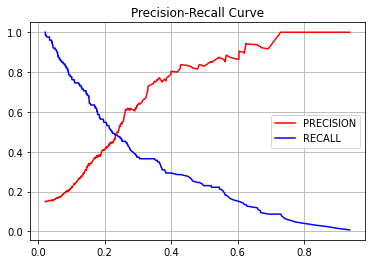

In [66]:
plt.plot(thresholds, precision[:-1], c ='r', label ='PRECISION') 

plt.plot(thresholds, recall[:-1], c ='b', label ='RECALL') 
plt.grid() 
plt.legend() 

plt.title('Precision-Recall Curve')

In [67]:
fscore = (2 * precision * recall) / (precision + recall)

In [69]:
index = np.argmax(fscore)
thresholdOpt = round(thresholds[index], ndigits = 4)
fscoreOpt = round(fscore[index], ndigits = 4)

In [70]:
print('Best Threshold: {} with F-Score: {}'.format(thresholdOpt, fscoreOpt))

Best Threshold: 0.264 with F-Score: 0.5205


In [125]:
threshold = thresholdOpt

In [130]:
test = X_test.sample(10)
test

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
394,10,141.0,2,0,1,23.0,149.7,112.0,25.45,162.5,118.0,13.81,220.3,115.0,9.91,7.6,2.0,2.05,3.0
2747,47,121.0,2,0,0,0.0,255.1,93.0,43.37,266.9,97.0,22.69,197.7,NaN,8.90,8.8,3.0,2.38,3.0
3305,16,51.0,1,0,1,43.0,158.2,94.0,26.89,213.2,105.0,18.12,190.4,91.0,8.57,8.5,2.0,2.30,2.0
3415,19,116.0,1,0,0,0.0,119.0,94.0,20.23,144.3,110.0,12.27,199.7,65.0,8.99,8.8,5.0,2.38,2.0
992,7,123.0,1,0,0,0.0,211.0,92.0,35.87,217.0,102.0,18.45,214.8,104.0,9.67,9.8,7.0,2.65,3.0
1727,43,136.0,0,0,0,0.0,269.8,106.0,45.87,228.8,101.0,19.45,257.5,106.0,11.59,10.1,8.0,2.73,1.0
1964,14,148.0,0,0,1,25.0,230.7,102.0,39.22,233.8,109.0,19.87,215.8,90.0,9.71,13.5,2.0,3.65,3.0
1584,34,99.0,1,0,0,0.0,145.6,102.0,24.75,230.9,87.0,19.63,181.5,86.0,8.17,11.4,7.0,3.08,1.0
2996,50,109.0,1,1,1,46.0,165.2,85.0,28.08,136.0,92.0,11.56,184.8,100.0,8.32,11.9,5.0,3.21,1.0
1568,32,107.0,1,0,0,0.0,222.3,101.0,37.79,286.0,111.0,24.31,249.4,117.0,11.22,12.1,4.0,3.27,1.0


In [131]:
print(loaded_model.predict_proba(test))
print(loaded_model.predict(test))

[[0.94789375 0.05210625]
 [0.37135084 0.62864916]
 [0.94123791 0.05876209]
 [0.89364294 0.10635706]
 [0.98301912 0.01698088]
 [0.27047778 0.72952222]
 [0.89813942 0.10186058]
 [0.95903354 0.04096646]
 [0.85381235 0.14618765]
 [0.53600296 0.46399704]]
[0 1 0 0 0 1 0 0 0 0]


In [132]:
y_pred_proba_new_threshold = (loaded_model.predict_proba(test)[:,1] >= threshold).astype(int)
y_pred_proba_new_threshold

array([0, 1, 0, 0, 0, 1, 0, 0, 0, 1])

In [ ]:
# p(a) = 0.7
# p(b) = 0.3
# if p(a)>=p(b):
#     then class a
# else class b

In [ ]:
# if p(1)>=0.43:
#     then class 1
# else class 0

In [ ]:
# p(1) = 0.45
# p(0) = 0.55